In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/aiffel

/content/drive/MyDrive/aiffel


# Cutmix와 Mixup 비교실험

|평가문항|상세기준|
|:---|:---|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로| 분석하였다.

### 1. Dataset 구성하기(Cutmix, Mixup)
- Dataset 로드
- Cutmix, Mixup 함수 각각 적용되도록(with_cutmix, with_mixup)
- Onehot encoding 함수 만들어주기

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteTPQQXF/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteTPQQXF/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


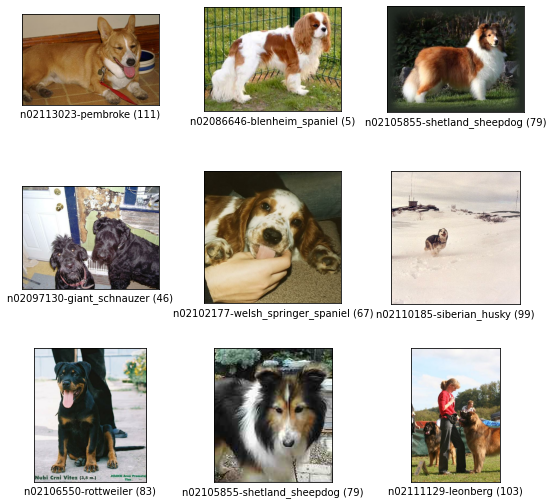

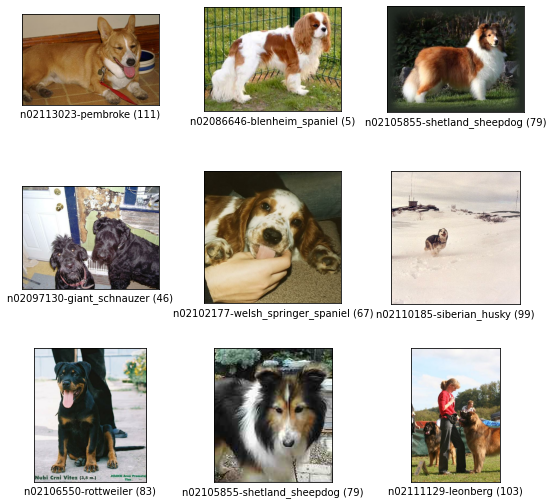

In [ ]:
tfds.show_examples(ds_train, ds_info)

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label
    # test set을 위한 onehot 함수 추가.

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('✔')

✔


In [ ]:
# Cutmix, Mixup dataset 만들기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('✔')

✔


### 2. Model Build

- Cutmix 적용된 것과 Mixup 적용된 것 나눠서 만들기.

In [ ]:

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('✔')

✔


In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('✔')

✔


In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 105s 123ms/step - loss: 3.9070 - accuracy: 0.1966 - val_loss: 3.0667 - val_accuracy: 0.2510
Epoch 2/20
750/750 [==============================] - 97s 129ms/step - loss: 3.0370 - accuracy: 0.4070 - val_loss: 1.4464 - val_accuracy: 0.5947
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 2.7635 - accuracy: 0.4803 - val_loss: 1.4689 - val_accuracy: 0.5947
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 2.5826 - accuracy: 0.5506 - val_loss: 1.2093 - val_accuracy: 0.6679
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 2.4375 - accuracy: 0.5885 - val_loss: 1.2848 - val_accuracy: 0.6402
Epoch 6/20
750/750 [==============================] - 92s 123ms/step - loss: 2.3174 - accuracy: 0.6223 - val_loss: 1.2401 - val_accuracy: 0.6556
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 2.2379 - accuracy: 0.6474 - val_loss: 1.2825 - val_accuracy: 0.

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 127s 123ms/step - loss: 3.7558 - accuracy: 0.2322 - val_loss: 3.7132 - val_accuracy: 0.1505
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 2.9284 - accuracy: 0.4527 - val_loss: 1.7837 - val_accuracy: 0.5141
Epoch 3/20
750/750 [==============================] - 92s 122ms/step - loss: 2.6875 - accuracy: 0.5401 - val_loss: 1.4169 - val_accuracy: 0.6066
Epoch 4/20
750/750 [==============================] - 96s 128ms/step - loss: 2.5140 - accuracy: 0.6033 - val_loss: 1.3138 - val_accuracy: 0.6376
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 2.4189 - accuracy: 0.6369 - val_loss: 1.1860 - val_accuracy: 0.6672
Epoch 6/20
750/750 [==============================] - 97s 129ms/step - loss: 2.3175 - accuracy: 0.6763 - val_loss: 1.2688 - val_accuracy: 0.6516
Epoch 7/20
750/750 [==============================] - 94s 126ms/step - loss: 2.2390 - accuracy: 0.7037 - val_loss: 1.2508 - val_accuracy: 0.

## 3. 훈련 과정 시각화

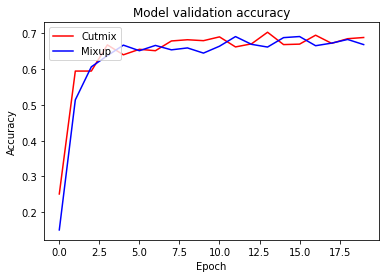

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix', 'Mixup'], loc='upper left')
plt.show()

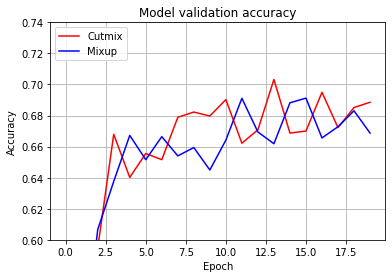

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix', 'Mixup'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.6, 0.74)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 4. Augmentation에 따른 성능 비교

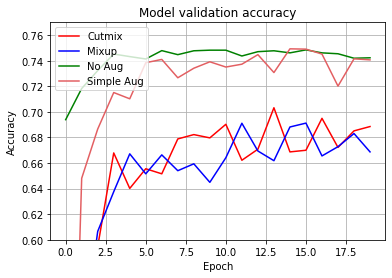

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug.history['val_accuracy'], '#e35f62')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix', 'Mixup','No Aug','Simple Aug'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.6, 0.77)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# 5. 회고

#### 20epoch을 기준으로 확인한 결과 
- No Augmentation이 0.74이상의 정확도로 제일 먼저 수렴하여 그 성능을 유지하였다. 
- 흔히 수행하는 Simple Augmentation의 경우가 제일 높은 수치의 accuracy를 보여주었다.
- Cutmix와 Mixup의 경우 아직 accuracy가 상승 추세를 그리고 있었고 epoch 수가 부족해보인다.
- Cutmix와 Mixup 사이의 성능 차이를 위를 바탕으로 판단하기에는 무리가 있으나 Cutmix가 빈번히 더 높은 accuracy를 보인 점에서 더 높은 값으로 수렴할 수 있을 것이라고 생각한다.
- 추가적인 epoch으로 시행해볼 예정이다.

---
# 이론 및 연습

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('✔')

✔


In [ ]:
def simple_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

print('✔')

✔


In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            simple_augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('✔')

✔


In [ ]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) #중앙을 기준으로 50~100% 만큼 랜덤하게 자름.
    image = tf.image.resize(image, [224,224])
    return image, label

print('✔')

✔


In [ ]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('✔')

94781440/94765736 [==============================] - 1s 0us/step
✔


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('✔')

✔


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('✔')

✔


In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 111s 132ms/step - loss: 0.3859 - accuracy: 0.9047 - val_loss: 1.0364 - val_accuracy: 0.6939
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1785 - accuracy: 0.9672 - val_loss: 0.9722 - val_accuracy: 0.7183
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0520 - accuracy: 0.9954 - val_loss: 0.9456 - val_accuracy: 0.7323
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0202 - accuracy: 0.9992 - val_loss: 0.9101 - val_accuracy: 0.7452
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0208 - accuracy: 0.9993 - val_loss: 0.9358 - val_accuracy: 0.7432
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0222 - accuracy: 0.9982 - val_loss: 0.9549 - val_accuracy: 0.7414
Epoch 7/20
750/750 [==============================] - 92s 122ms/step - loss: 0.0086 - accuracy: 0.9997 - val_loss: 0.9468 - val_accuracy: 0.

In [ ]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 103s 126ms/step - loss: 2.2707 - accuracy: 0.4299 - val_loss: 3.1568 - val_accuracy: 0.2340
Epoch 2/20
750/750 [==============================] - 90s 119ms/step - loss: 0.9279 - accuracy: 0.7350 - val_loss: 1.2233 - val_accuracy: 0.6481
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 0.5057 - accuracy: 0.8590 - val_loss: 1.1020 - val_accuracy: 0.6866
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.3239 - accuracy: 0.9164 - val_loss: 0.9837 - val_accuracy: 0.7151
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 0.1942 - accuracy: 0.9563 - val_loss: 1.0484 - val_accuracy: 0.7102
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0897 - accuracy: 0.9848 - val_loss: 0.9250 - val_accuracy: 0.7385
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0498 - accuracy: 0.9941 - val_loss: 0.9371 - val_accuracy: 0.

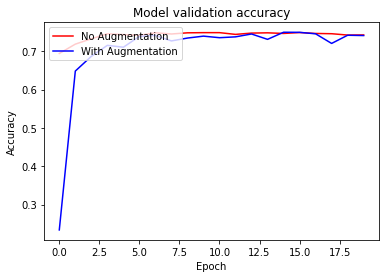

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

### Augmentation 전후 비교.
- 20epoch 결과로 보았을 때 생각보다는 augmentation 전의 결과가 안정적으로 좋았다. Augmentation의 랜덤한 시행으로 약간 들쑥날쑥한 val accuracy가 나온 것 같다.
- 하지만 최고 accuracy는 augmentation 후의 결과에서 나왔고, 더 많은 epoch에서는 결과가 추월할 것으로 예상된다.

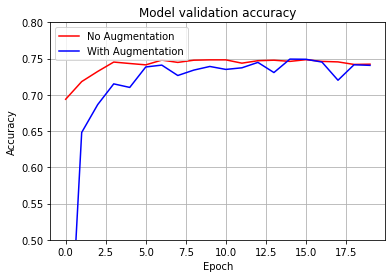

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## More Augmentation : Cutmix and Mixup
CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법. 이미지 데이터를 자르고 합쳐서 새로운 데이터를 만들어서 이용하는 방법.

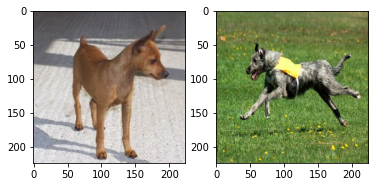

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(108, shape=(), dtype=int32) tf.Tensor(176, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(129, shape=(), dtype=int32)


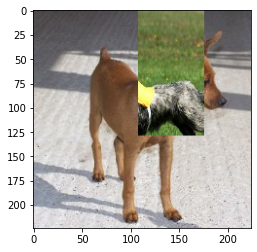

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역 = 중앙 부분의 image_a의 왼쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역 = 중앙 부분의 image_a의 오른쪽 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1) # 중앙부는 왼쪽 가운데 오른쪽 세로 방향으로 잘랐기 때문에 x축 방향으로 concat
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    #이미지를 상 중 하 구역으로 나누어서 concat해줌. 그래서 y축 기준으로 함.
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# mix two labels
# 사용된 사진 비율에 따라 label링도 비율로 바꿔서 표현.
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.17482461,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('✔')

✔


## More Augmentation : Cutmix and Mixup
Mixup은 투명도를 준 것과 비슷한 맥락으로 두 이미지를 말 간단하게 겹쳐서 mix하는 기법이다. 라벨 또한 섞인 비율에 맞게 만들어준다.

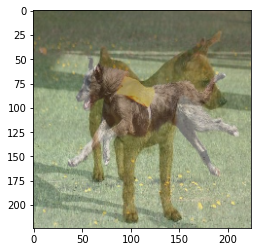

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.4448774 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.5551226 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('✔')

✔
